# Variable Selection in Azure ML Jupyter Notebook
Lixun Zhang  
Nov 10, 2015

## 1 Introduction
Before starting this example, it is assumed that you are familiar with Azure Machine Learning (Azure ML) experiments and the process for publishing Azure web service from Python. If not, you can refer to [Tutorial for Using Azure Machine Learning Notebook][tutorial link]. 

The purpose of this example is to demonstrate how to use a feature selection technique not available for Azure ML experiments. This process can be completed with Azure ML Jupyter notebook, a cloud-based service that's part of Azure ML environment.

As [Figure 1][pic 1] shows, there are three Feature Selection options for an Azure ML experiment:
 1. Filter Based Feature Selection
 2. Fisher Linear Discriminant Analysis
 3. Permutation Feature Importance

Among these, Fisher Linear Discriminant Analysis is actually a dimension reduction technique for cases where the response variable is categorical. Filter Based Feature Selection uses univariate analysis to select features (using metrics such as Pearson Correlation, Chi Squared, etc). Permutation Feature Importance ranks variables by calculating the difference in model performance metrics before and after random permutations of feature values. As the paper [Dimension Reduction vs. Variable Selection][paper link] describes, there are a wide variety of feature selection and dimension reduction techniques. In what follows we'll illustrate how to use recursive feature elimination within an Azure ML Jupyter notebook. 

[![Figure 1][pic 1]][pic 1] Figure 1

[tutorial link]: link
[paper link]: http://rd.springer.com/chapter/10.1007%2F11558958_113
[pic 1]: https://cloud.githubusercontent.com/assets/9322661/10466244/4e5ae462-71c1-11e5-8c01-a96769336daf.PNG

## 2 Read data
Following the same step as in [Tutorial for Using Azure Machine Learning Notebook][tutorial link], we first create an Azure ML experiment to read the Boston housing data and then use the following code to bring the data from the experiment into the current Python session.

[tutorial link]: link

In [1]:
from azureml import Workspace
ws = Workspace(
 workspace_id='b2bbeb56a1d04e1599d2510a06c59d87',
 authorization_token='a3978d933cd84e64ab583a616366d160',
 endpoint='https://studioapi.azureml.net'
)
experiment = ws.experiments['b2bbeb56a1d04e1599d2510a06c59d87.f-id.911630d13cbe4407b9fe408b5bb6ddef']
ds = experiment.get_intermediate_dataset(
 node_id='a0a931cf-9fb3-4cb9-83db-f48211be560c-323',
 port_name='Results dataset',
 data_type_id='GenericCSV'
)
frame = ds.to_dataframe()

mydata = frame
mydata.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## 3 Recursive Feature Elimination
The sklearn package has several feature selection methods and details can be found at the [documentation][feature link] site. In this example we'll be using the recursive feature elimination method. This process starts with all variables and assign weights to them. Those with small weights are first removed. The remaining variables are used to refit the model and the process repeats. 

We start by importing the packages that'll be used. 

[feature link]: http://scikit-learn.org/stable/modules/feature_selection.html

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.feature_selection import RFECV

The following lines of code first scale the features then identify the selected features with recursive feature elimination.

Optimal number of features : 6
Features selected: ['crim', 'nox', 'rm', 'dis', 'ptratio', 'lstat']


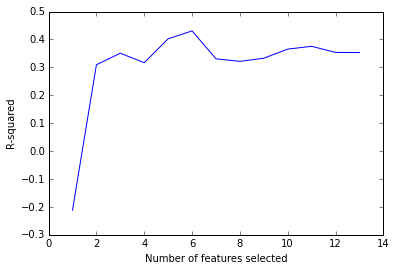

In [3]:
# create X and y
feature_cols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']
X = mydata[feature_cols]
y = mydata.medv

# initiate the linear model
lm = LinearRegression()

# scale the features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_minmax = min_max_scaler.fit_transform(X)
x_scaled_minmax_df = pd.DataFrame(x_scaled_minmax, columns = feature_cols)

# recursive feature elimination with cross validation, using r-squared as metric
rfecv = RFECV(estimator=lm, step=1, cv=5, scoring='r2')
rfecv.fit(x_scaled_minmax_df, y)

# print the optimal number of feature
print("Optimal number of features : %d" % rfecv.n_features_)

# save the selected features
feature_cols_selected = list(np.array(feature_cols)[rfecv.support_])
print("Features selected: " + str(feature_cols_selected))

# plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("R-squared")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Once the features to include are selected, we can use them to fit the model. While the scaled features were used in the RFE step above, we'll use the original values for fitting the model. This way we don't have to tranform the data when making predictions.

In [4]:
#%% fit model with selected features
X_new = mydata[feature_cols_selected]
lm2 = LinearRegression()
lm2.fit(X_new, y)

# print the R-squared
print("The R-squared value is: {0:0.4f} \n".format(lm2.score(X_new, y)))
# save intercept and coefficients
param_df = pd.DataFrame({"Features": ['intercept'] + feature_cols_selected, "Coef": [lm2.intercept_] + list(lm2.coef_)})
cols = param_df.columns.tolist()
cols = cols[-1:]+cols[:-1]
param_df = param_df[cols]
print(param_df)

The R-squared value is: 0.7114 

    Features       Coef
0  intercept  35.545530
1       crim  -0.072024
2        nox -17.006654
3         rm   4.251961
4        dis  -1.203345
5    ptratio  -1.000803
6      lstat  -0.553532


Next we'll use the model to make predictions. Typically, predictions are done on a validation dataset. Here, however, the training dataset is used for illustraton purposes.

In [5]:
# assign test data
newX = X_new
newY = y

# join predictions with original data
predicted = lm2.predict(newX)
predicted_df = pd.DataFrame({"predicted": predicted})
mydata_with_pd = newX.join(newY).join(predicted_df)
mydata_with_pd.head()

# check performance metrics
import numpy as np
obs = mydata_with_pd.medv
pred = mydata_with_pd.predicted

mae = np.mean(abs(pred-obs))
rmse = np.sqrt(np.mean((pred-obs)**2))
rae = np.mean(abs(pred-obs))/np.mean(abs(obs-np.mean(obs)))
rse = np.mean((pred-obs)**2)/np.mean((obs-np.mean(obs))**2)

print("Mean Absolute Error: {0:0.6f}".format(mae))
print("Root Mean Squared Error: {0:0.6f}".format(rmse))
print("Relative Absolute Error: {0:0.6f}".format(rae))
print("Relative Squared Error: {0:0.6f}".format(rse))

Mean Absolute Error: 3.466150
Root Mean Squared Error: 4.935936
Relative Absolute Error: 0.521445
Relative Squared Error: 0.288600


## 4 Web Service
### 4.1 Set up a web service
The following code sets up a web service and prints information about it. The [Tutorial for Using Azure Machine Learning Notebook][tutorial link] provides a more detailed coverage about this step.

[tutorial link]: link

In [6]:
from azureml import services
@services.publish('b2bbeb56a1d04e1599d2510a06c59d87', 'a3978d933cd84e64ab583a616366d160')
@services.types(crim = float, nox=float, rm=float, dis=float, ptratio=float, lstat=float)
@services.returns(float)
def demoserviceupdate(crim, nox, rm, dis, ptratio, lstat):
    feature_vector = [crim, nox, rm, dis, ptratio,  lstat]
    return lm2.predict(feature_vector)

# information about the web service
print("url: " + demoserviceupdate.service.url + "\n")
print("api_key: " + demoserviceupdate.service.api_key + "\n")
print("help_url: " + demoserviceupdate.service.help_url + "\n")
print("service id: " + demoserviceupdate.service.service_id + "\n")

url: https://ussouthcentral.services.azureml.net/workspaces/b2bbeb56a1d04e1599d2510a06c59d87/services/273512f800a345ce8d37df88feafe847/execute?api-version=2.0

api_key: EhFzbaRrdmj3HSfPGs714s2OdeZdtJXjwFBu07fVgZ2mLAv1/qsh1t/zX8v6YUGgj4r8glAPq+f5xIxyCsbDoA==

help_url: https://studio.azureml.net/apihelp/workspaces/b2bbeb56a1d04e1599d2510a06c59d87/webservices/e366acbd3fc148879db743e60806e2f9/endpoints/273512f800a345ce8d37df88feafe847/score

service id: e366acbd3fc148879db743e60806e2f9



### 4.2 Consume a web service

Following the same steps as described in [Tutorial for Using Azure Machine Learning Notebook][tutorial link], we can copy and paste the Python code for consuming the web service. Replace the default api_key with the value for your service and enter input values for two samples. Running the code will return the predictions for the samples you entered. 

[tutorial link]: link

In [7]:
import urllib2
# If you are using Python 3+, import urllib instead of urllib2

import json 


data =  {

        "Inputs": {

                "input1":
                {
                    "ColumnNames": ["crim", "lstat", "nox", "rm", "ptratio", "dis"],
                    "Values": [ [ "0.00632", "4.98", "0.538", "6.575", "15.3", "4.0900" ], 
                               [ "0.02731", "9.14", "0.469", "6.421", "17.8", "4.9671" ], ]
                },        },
            "GlobalParameters": {
}
    }

body = str.encode(json.dumps(data))

url = 'https://ussouthcentral.services.azureml.net/workspaces/b2bbeb56a1d04e1599d2510a06c59d87/\
services/8c035f34db59446c86e46f9bdfe0ad2a/execute?api-version=2.0&details=true'
api_key = 'F36t+Klp90HQ0WTcvgHIcbHzyJ+/LbYNGesQ9GSugHb23AVSh/b6V03yiV89aqpbT4PnhyTcJYTnWNOOLTeQSQ==' \
# Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib2.Request(url, body, headers) 

try:
    response = urllib2.urlopen(req)

    # If you are using Python 3+, replace urllib2 with urllib.request in the above code:
    # req = urllib.request.Request(url, body, headers) 
    # response = urllib.request.urlopen(req)

    result = response.read()
    print(result) 
except urllib2.HTTPError, error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())

    print(json.loads(error.read()))                 


{"Results":{"output1":{"type":"table","value":{"ColumnNames":["0"],"ColumnTypes":["Double"],"Values":[["31.3615775830933"],["26.0185683269088"]]}},"output2":{"type":"table","value":{"ColumnNames":["Standard Output","Standard Error","Graphics"],"ColumnTypes":["String","String","String"],"Values":[["data:text/plain,","data:text/plain,",null]]}}}}


## 5 Conclusion
In this example we started by briefly reviewing the feature selection techniques available for Azure ML's experiments. Then we used the Boston housing dataset to illustrate how to use a technique that's not available for Azure ML's experiments: recursive feature selection. The sklearn package implements several other feature techniques and you can find more information from the [documentation][documentation link] site.

---  
Created by a Microsoft Employee.  
Copyright © Microsoft. All Rights Reserved.
[documentation link]: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection